In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec

import re
import collections

from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn import svm                                  #SVM分类器
from sklearn.ensemble import RandomForestClassifier      #随机森林分类器
from sklearn.naive_bayes import  GaussianNB              #朴素贝叶斯
from sklearn.linear_model import LogisticRegression        #逻辑斯特回归
from sklearn.model_selection import train_test_split     
from sklearn.metrics import accuracy_score
from sklearn import metrics

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

In [128]:
data=pd.read_csv(r"C:\Users\YUE\Desktop\interface6.csv",dtype={'Reviews':str})
data.head()

,Rating,Sentiment,Review_1,Review_2,Reviews,Date,Version,Nation
0,1,0,worst design . the video recommendation below ...,remove video recommendation below the video .,worst design . the video recommendation below ...,2017/1/20,11.49,SG
1,1,0,with new update it be completely unable to loa...,bad design .,with new update it be completely unable to loa...,2017/1/20,11.49,SG
2,1,0,"the more update be do , the worse the app get ...",not happy with update at all .,"the more update be do , the worse the app get ...",2017/1/5,11.47.1,SG
3,1,0,"the advert be too plentiful , to the point tha...",bad . just look at all the most recent review ...,"the advert be too plentiful , to the point tha...",2016/12/26,11.47.1,SG
4,1,0,"the advert be too plentiful , to the point tha...",bad . just look at all the most recent review ...,"the advert be too plentiful , to the point tha...",2016/12/7,11.47,SG


In [129]:
#预处理
new_data=data[["Sentiment","Reviews"]]  #获取指定列
new_data.head()

,Sentiment,Reviews
0,0,worst design . the video recommendation below ...
1,0,with new update it be completely unable to loa...
2,0,"the more update be do , the worse the app get ..."
3,0,"the advert be too plentiful , to the point tha..."
4,0,"the advert be too plentiful , to the point tha..."


In [130]:
#简单预处理
def clean_text(text):
    text= text.replace('\n'," ") #用空格代替新的行
    text=re.sub(r"-"," ",text)  #把用“-”连接的单词分开 （close-up分成close和 up）
    pure_text=''
    for letter in text:        #去除字母和空格
        letter=letter.lower()
        if letter.isalpha() or letter==' ':
            pure_text+=letter
    text=' '.join(word for word in pure_text.split() if len(word)>1)
    return text



In [131]:
#错词纠正算法
def token(text):
    
    return re.findall('[a-z]+', text.lower())

path=r'C:\Users\YUE\Desktop\big.txt'
with open(path) as f:
    WORDS=token(f.read())
WORD_COUNTS=collections.Counter(WORDS)

def known(words):
    return {w for w in words if w in WORD_COUNTS}

def edits0(word):
    return {word}


def edits1(word):
    alphabet='abcdefghijklmnopqrstuvwxyz'
    
    def splits(word): 
        return [(word[:i],word[i:]) for i in range(len(word)+1)]
    
    pairs=splits(word)
    deletes=[a+b[1:] for (a,b) in pairs if b]
    transposes=[a+b[1]+b[0]+b[2:] for (a,b) in pairs if len(b)>1]
    replaces=[a+c+b[1:] for (a,b) in pairs for c in alphabet if b]
    inserts=[a+c+b for (a,b) in pairs for c in alphabet]
    return set(deletes+ transposes+ replaces+ inserts)

def edits2(word):
    return{e2 for e1 in edits1(word) for e2 in edits1(e1)}

def correct(word):
    candidates=(known(edits0(word)) or
                known(edits1(word)) or
                known(edits2(word)) or
                [word] )
    return max(candidates,key=WORD_COUNTS.get)

def correct_match(match):
    word=match.group()
    
    def case_of(text):
        return (str.upper if text.isupper() else
                str.lower if text.islower() else
                str.title if text.istitle() else
                str )
    return case_of(word)(correct(word.lower()))


def correct_text_generic(text):
    return re.sub('[a-zA-Z]+', correct_match, text)

In [132]:
#错词纠正
new_df=new_data['Reviews'].copy()
docs=new_df.apply(lambda s:clean_text(s))
doclist=docs.values
reviews_1=[]
for sentence in doclist:
    raw_sentence=nltk.word_tokenize(sentence)
    for word in sentence:
        word=correct_text_generic(word)
    reviews_1.append(raw_sentence)
#print(reviews_1)

In [133]:
#词性还原算法
def get_word_pos(tag):
#     if tag.startswith('J'):
#         return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
#     elif tag.startswith('N'):
#         return wordnet.NOUN
#     elif tag.startswith('R'):
#         return wordnet.ADV
    else:
        return None

In [134]:
#词性还原
reviews_2=[]
for sentence in reviews_1:
    tagged_sent=pos_tag(sentence)
    wnl=WordNetLemmatizer()
    lemmas_sent=[]
    for tag in tagged_sent:
        wordnet_pos=get_word_pos(tag[1]) or wordnet.NOUN
        lemmas_sent.append(wnl.lemmatize(tag[0],pos=wordnet_pos))
    reviews_2.append(lemmas_sent)
#print(reviews_2)

In [135]:
#停止词去除
def remove_stopword():
    stopword = []
    with open(r'C:\Users\YUE\Desktop\english.txt', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            line = line.replace('\n', '')
            stopword.append(line)
    return stopword

my_stoplst = ["app", "good", "excellent", "please", "they", "very", "too", 
                  "yeah", "amazing", "lovely", "perfect", "much", "best", "yup", "super", "thank",
                  "great",
                  "really", "omg", "gud", "yes", "cool", "fine", "hello", "alright", "poor", "plz", "pls", "google",
                  "facebook",
                  "three", "ones", "one", "two", "five", "four", "old", "new", "asap", "version", "times", "update",
                  "star",
                  "first",
                  "rid", "bit", "annoying", "beautiful", "dear", "master", "evernote", "per", "line", "oh", "ah",
                  "cannot", "doesnt", "won't", "dont", "unless", "you're", "aren't", "i'd", "can't", "wouldn't",
                  "around",
                  "i've", "i'll", "gonna", "ago", "you'll", "you'd", "28th", "gen", "it'll", "vice", "would've",
                  "wasn't",
                  "year", "boy", "they'd",
                  "isnt", "1st", "i'm","im", "nobody", "youtube", "isn't", "don't", "2016", "2017", "since", "near", "god","video",
                   "none","hi","ive","didnt","af","io"]

stopset=list(stopwords.words('english'))

In [136]:
stop_words=stopset+my_stoplst
texts=[[word for word in doc if word not in stop_words] for doc in reviews_2]

In [137]:
print(texts[1])

['completely', 'unable', 'load', 'probably', 'cause', 'thousand', 'lose', 'advertisement', 'revenue', 'well', 'lose', 'money', 'bad', 'design']


In [138]:
for i in range(len(data["Reviews"])):
    new_data["Reviews"][i]=texts[i]
print(new_data)

      Sentiment                                            Reviews
0             0  [worst, design, recommendation, keep, show, tr...
1             0  [completely, unable, load, probably, cause, th...
2             0       [worse, get, load, interface, shitty, happy]
3             0  [advert, plentiful, point, advert, cause, prob...
4             0  [advert, plentiful, point, advert, cause, prob...
...         ...                                                ...
1637          0  [regret, want, long, sub, list, leave, wan, na...
1638          0  [strong, start, beg, simple, function, complic...
1639          0  [everything, garbage, impossible, watch, anyth...
1640          1  [let, say, fan, layout, would, like, back, rea...
1641          0  [anyone, remember, actually, work, latest, enc...

[1642 rows x 2 columns]


In [139]:
#统计正、负面情绪评论个数
postive_num=0
negtive_num=0
for i in new_data["Sentiment"]:
    if i==1:
        postive_num+=1
    if i==0:
        negtive_num+=1 
print(postive_num)
print(negtive_num)

190
1452


In [140]:
#将负面和正面情绪的评论分成两个表，并重新归置索引
pos_df=new_data.query('Sentiment==1')
neg_df=new_data.query('Sentiment==0')
pos_df=pos_df.reset_index(drop=True)
neg_df=neg_df.reset_index(drop=True)
print(pos_df)
print("____________________")
print(neg_df)

     Sentiment                                            Reviews
0            1  [latest, whole, layout, change, find, quite, e...
1            1  [everything, work, well, except, minor, bug, m...
2            1                       [slick, watch, dozen, thing]
3            1  [latest, sync, audio, duplicate, comment, scro...
4            1  [improve, immensely, higher, quality, layout, ...
..         ...                                                ...
185          1  [layout, terrible, like, layout, easier, watch...
186          1  [like, slide, tab, allow, see, name, subscript...
187          1  [hate, stupid, layout, think, change, original...
188          1  [far, pleasant, experience, like, able, go, se...
189          1  [let, say, fan, layout, would, like, back, rea...

[190 rows x 2 columns]
____________________
      Sentiment                                            Reviews
0             0  [worst, design, recommendation, keep, show, tr...
1             0  [completely,

In [195]:
#样本平衡(Neg远远多于Pos)
import random
random_list=sorted(random.sample(range(0,1452),452))
new_neg_df=neg_df.drop(index=random_list)
new_neg_df=new_neg_df.reset_index(drop=True)
print(new_neg_df)

     Sentiment                                            Reviews
0            0  [worst, design, recommendation, keep, show, tr...
1            0  [completely, unable, load, probably, cause, th...
2            0       [worse, get, load, interface, shitty, happy]
3            0  [advert, plentiful, point, advert, cause, prob...
4            0  [layout, cant, even, watch, freeze, even, thou...
..         ...                                                ...
995          0  [like, try, view, device, experience, thing, t...
996          0  [regret, want, long, sub, list, leave, wan, na...
997          0  [strong, start, beg, simple, function, complic...
998          0  [everything, garbage, impossible, watch, anyth...
999          0  [anyone, remember, actually, work, latest, enc...

[1000 rows x 2 columns]


In [196]:
#样本平衡(Pos远远多于Neg)
#import random
#random_list=sorted(random.sample(range(0,321),156))
#new_pos_df=pos_df.drop(index=random_list)
#new_pos_df=new_pos_df.reset_index(drop=True)
#print(new_pos_df)

In [197]:
#test_data=pd.concat([pos_df,neg_df])   #Pos远远多于Neg
test_data=pd.concat([pos_df,new_neg_df])   #Neg远远多于Pos
#3test_data=test_data.reset_index(drop=True)
#print(test_data)
#test_data=pd.concat([pos_df,neg_df])
print(test_data)

     Sentiment                                            Reviews
0            1  [latest, whole, layout, change, find, quite, e...
1            1  [everything, work, well, except, minor, bug, m...
2            1                       [slick, watch, dozen, thing]
3            1  [latest, sync, audio, duplicate, comment, scro...
4            1  [improve, immensely, higher, quality, layout, ...
..         ...                                                ...
995          0  [like, try, view, device, experience, thing, t...
996          0  [regret, want, long, sub, list, leave, wan, na...
997          0  [strong, start, beg, simple, function, complic...
998          0  [everything, garbage, impossible, watch, anyth...
999          0  [anyone, remember, actually, work, latest, enc...

[1190 rows x 2 columns]


In [198]:
sentences=[]
for raw_sent in test_data["Reviews"]:
    sentences.append(raw_sent)


#word2vec模型建立
import multiprocessing
num_features=300                          #生成的单词向量的维数
min_word_count=1                          #最小字数的阈值
num_workers=multiprocessing.cpu_count()   #并行运行的线程数
context_size=3                            #上下文窗口长度
seed=1                                    #使得结果重现

word2vec_model=Word2Vec(sentences=sentences,
                        sg=1,
                        seed=seed,
                        workers=num_workers,
                        vector_size=num_features,
                        min_count=min_word_count,
                        window=context_size
                        )

In [199]:
#每个句子的向量是字向量的均值
def get_vec(sent):
    sentence_vec=[]
    for word in sent:
        sentence_vec.append(word2vec_model.wv[word])
    return sentence_vec

def build_vec(sentences):
    test_vec=[]
    for sentence in sentences:
        vec=get_vec(sentence)
        if len(vec)!=0:
            test_vec.append(sum(vec)/len(vec))
    return test_vec
        

In [211]:
#机器学习来预测结果
#Train test split
y=pd.DataFrame(test_data["Sentiment"])
x=pd.DataFrame(build_vec(sentences))
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2)

In [212]:
#随机森林
RFC_clf=RandomForestClassifier(n_estimators=50,random_state=100,class_weight='balanced')
RFC_clf=RFC_clf.fit(xtrain,ytrain)
score_rfc=RFC_clf.score(xtest,ytest)
predict_test=RFC_clf.predict(xtest)
print(metrics.classification_report(predict_test,ytest))
print("随机森林的accuracy为：",score_rfc)

              precision    recall  f1-score   support

           0       0.99      0.85      0.91       233
           1       0.08      0.60      0.14         5

    accuracy                           0.84       238
   macro avg       0.53      0.72      0.52       238
weighted avg       0.97      0.84      0.90       238

随机森林的accuracy为： 0.8403361344537815


In [213]:
#Svm
SVM_clf=svm.SVC(kernel='rbf',class_weight='balanced')
SVM_clf=SVM_clf.fit(xtrain,ytrain)
score_svm=SVM_clf.score(xtest,ytest)
predict_test=SVM_clf.predict(xtest)
print(metrics.classification_report(predict_test,ytest))
print("SVM的accuracy为：",score_svm)

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       197
           1       0.23      0.22      0.23        41

    accuracy                           0.74       238
   macro avg       0.53      0.53      0.53       238
weighted avg       0.73      0.74      0.74       238

SVM的accuracy为： 0.7394957983193278


In [214]:
#朴素贝叶斯
NB_clf=GaussianNB()
NB_clf=NB_clf.fit(xtrain,ytrain)
score_NB=NB_clf.score(xtest,ytest)
predict_test=NB_clf.predict(xtest)
print(metrics.classification_report(predict_test,ytest))
print("NB的accuracy为：",score_NB)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       190
           1       0.26      0.21      0.23        48

    accuracy                           0.72       238
   macro avg       0.53      0.53      0.53       238
weighted avg       0.70      0.72      0.71       238

NB的accuracy为： 0.7184873949579832


In [215]:
#逻辑斯特回归
LR_clf=LogisticRegression(penalty='l2', class_weight='balanced')
LR_clf=LR_clf.fit(xtrain,ytrain)
score_LR=LR_clf.score(xtest,ytest)
predict_test=LR_clf.predict(xtest)
print(metrics.classification_report(predict_test,ytest))
print("LR的accuracy为：",score_LR)

              precision    recall  f1-score   support

           0       0.50      0.86      0.63       115
           1       0.59      0.19      0.28       123

    accuracy                           0.51       238
   macro avg       0.54      0.52      0.46       238
weighted avg       0.55      0.51      0.45       238

LR的accuracy为： 0.5126050420168067


In [132]:
#情感倾向预测
sentenced_1=['layout', 'get', 'ebay', 'item', 'nt' ,'keep' ,'like']
avg_vec_1=sum(get_vec(sentenced_1))/len(get_vec(sentenced_1))   #第1个主题的平均向量
print(RFC_clf.predict(avg_vec_1.reshape(1,-1)))  

sentenced_2=['interface', 'ebay', 'user', 'latest', 'web' ,'site' ,'notification']
avg_vec_2=sum(get_vec(sentenced_2))/len(get_vec(sentenced_2))   #第2个主题的平均向量
print(RFC_clf.predict(avg_vec_2.reshape(1,-1)))  

sentenced_3=['easy', 'use', 'interface', 'nt', 'ebay' ,'option' ,'layout']
avg_vec_3=sum(get_vec(sentenced_3))/len(get_vec(sentenced_3))   #第3个主题的平均向量
print(RFC_clf.predict(avg_vec_3.reshape(1,-1))) 

sentenced_4=['design', 'use', 'item', 'look', 'search' ,'nt' ,'buy']
avg_vec_4=sum(get_vec(sentenced_4))/len(get_vec(sentenced_4))   #第4个主题的平均向量
print(RFC_clf.predict(avg_vec_4.reshape(1,-1)))  


[0]
[1]
[1]
[0]


0.7666666666666666 211


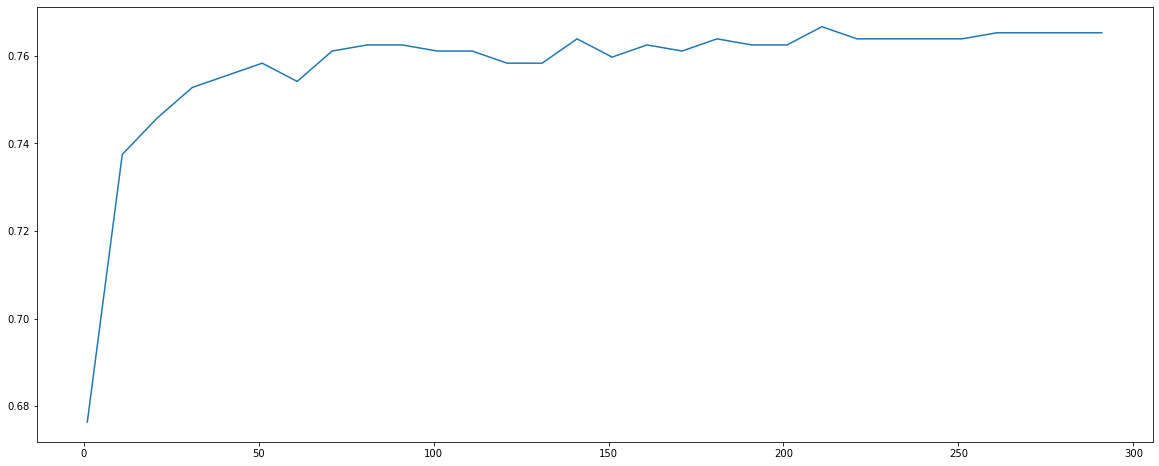

In [101]:
score1=[]
for i in range(0,300,10):
    rfc=RandomForestClassifier(n_estimators=i+1,n_jobs=-1,random_state=90)
    score=cross_val_score(rfc,x,y,cv=10).mean()
    score1.append(score)
    
print(max(score1),(score1.index(max(score1))*10)+1)  #最大的分数 以及它的索引值

plt.figure(figsize=(20,8))
plt.plot(range(1,300,10),score1)
plt.show()

In [103]:
#网格搜索  调整max_depth
param_grid={
           "max_depth":np.arange(1,20,1)
}
rfc=RandomForestClassifier(n_estimators=211,random_state=90)
GS=GridSearchCV(rfc,param_grid,cv=10)
GS.fit(x,y)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=211,
                                              random_state=90),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [104]:
GS.best_params_

{'max_depth': 15}

In [105]:
GS.best_score_

0.7652777777777778

In [ ]:
#svm
